Make nice COS spectra plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/5tb_storage1/cc_cet/hst/data/'
x1ds = glob.glob(path+'*x1dsum.fits')
x1ds

['/media/david/5tb_storage1/cc_cet/hst/data/ldlc01010_x1dsum.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51010_x1dsum.fits']

Text(0, 0.5, 'Flux (erg s$^{-1}$ cm$^{-2}$ \\AA$^{-1}$)')

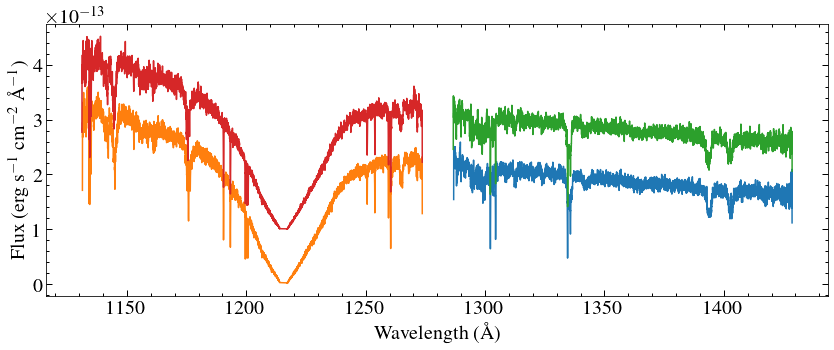

In [3]:
smooth = 5
for i, x in enumerate(x1ds):
    data = fits.getdata(x,1)
    for dt in data:
        w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
        w, f, e = w[mask], f[mask], e[mask]
        f = convolve(f,Box1DKernel(smooth))
        e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
        plt.plot(w, f+0.5*np.mean(f)*i)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

Just show one spectrum and a bunch of lines?

In [4]:
ism = Table.read('../../ism_lines.csv')
ism.dtype.names

('line', 'rest_lambda')

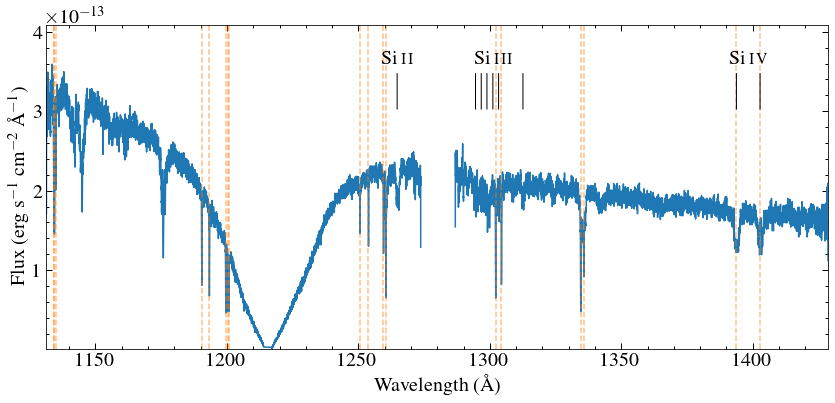

In [5]:
si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775,1402.770]
plt.figure(figsize=(12, 6))
smooth = 5
x = x1ds[0]
data = fits.getdata(x,1)
w0, w1 = 10000, 0
for dt in data:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    if w[0] < w0:
        w0= w[0]
    if w[-1] > w1:
        w1 = w[-1]
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
[plt.axvline(line, ls='--', c='C1', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(w0, w1)
plt.ylim(0.1e-14, 4.09e-13)

names = ['Si\,{\sc ii}', 'Si\,{\sc iii}', 'Si\,{\sc iv}']
lines = [si2, si3, si4]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 3.e-13), xytext=(line, 3.5e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 3.e-13), xytext=(np.mean(si), 3.6e-13), horizontalalignment='center')
    



#[plt.annotate('',(line, 3.5e-13), xytext=(line, 4e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si3]
#plt.annotate('Si\,{\sc iii}',(np.mean(si3), 3.5e-13), xytext=(np.mean(si3), 4.1e-13), horizontalalignment='center')

#[plt.annotate('',(line, 3.5e-13), xytext=(line, 4e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
#plt.annotate('Si\,{\sc iv}',(np.mean(si4), 3.5e-13), xytext=(np.mean(si4), 4.1e-13), horizontalalignment='center')


plt.tight_layout()
plt.savefig('plots/cc_cet_cos.pdf')

Looking for variation in the split spectra (try S iv lines)

(0.0, 3e-13)

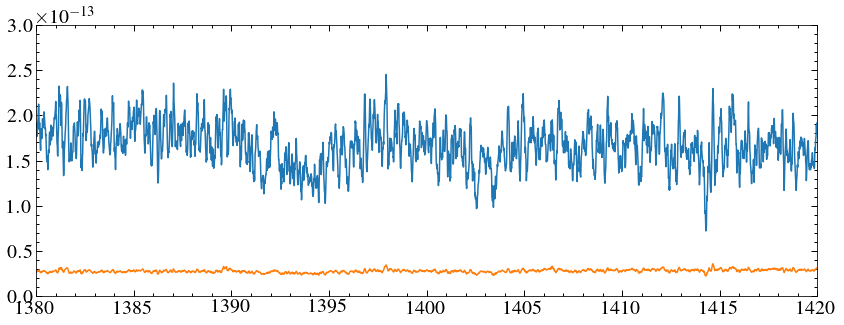

In [6]:
smooth=10
npath = '/media/david/5tb_storage1/cc_cet/hst/newx1ds/'
nx1ds = glob.glob(npath+'*100*x1d.fits')
data = fits.getdata(nx1ds[9], 1)[0]
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
plt.plot(w, f)
plt.plot(w,e)
plt.xlim(1380, 1420)
plt.ylim(0, 3e-13)

In [7]:
times  = []
for x in nx1ds:
    hdr = fits.getheader(x,1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    times.append(ti)
    
args = np.argsort(np.array(times))
nx1ds = np.array(nx1ds)[args]
times = np.array(times)[args]
    

In [8]:
"""from matplotlib.animation import FuncAnimation
smooth=50

fig, ax = plt.subplots(figsize=(5,5))
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
#ax[0].set_ylim(0.4, 1.2)
ax.set_xlim(1380.1, 1414.9)
ax.set_ylim(1.11e-13, 2.09e-13)

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
ax.axvline(1393.775, ls='--', c='C1', alpha=0.5)
ax.axvline(1402.770, ls='--', c='C1', alpha=0.5)
#[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]

#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
line1, = ax.step(w,f, where='mid')
t0 = fits.getheader(nx1ds[0],1)['EXPSTART']
an = ax.annotate('', (0.75, 0.1), xycoords ='axes fraction')
obs = 1
def update(i):
    #time = t[i]
    #line.set_xdata([t[i], t[i]])
    #ext = hdul[1::][i]
    hdr = fits.getheader(nx1ds[i],1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    if ti > 58152:
        obs=2
    else:
        obs = 1
    data = fits.getdata(nx1ds[i],1)[0]
    w, f = data['WAVELENGTH'], data['FLUX']
    f = convolve(f,Box1DKernel(smooth))
    line1.set_xdata(w)
    line1.set_ydata(f)
    
   ## if ti > t0+2:
     #   t0 = ti
      #  obs =
    an.set_text('Ob {0}'.format(obs))
 #   print(ti)
    return ax, line1, an
#ax.legend()
anim = FuncAnimation(fig, update, frames=np.arange(len(nx1ds)), interval=300)
anim.save('hst.gif', dpi=80, writer='imagemagick')
plt.show()

"""

"from matplotlib.animation import FuncAnimation\nsmooth=50\n\nfig, ax = plt.subplots(figsize=(5,5))\nfig.set_tight_layout(True)\n\n#ax[0].plot(t, f_lc)\n#ax[0].set_xlabel('Time (s)')\n#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')\n#ax[0].set_ylim(0.4, 1.2)\nax.set_xlim(1380.1, 1414.9)\nax.set_ylim(1.11e-13, 2.09e-13)\n\n#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)\nax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \\AA$^{-1}$)')\nax.set_xlabel('Wavelength (\\AA)')\nax.axvline(1393.775, ls='--', c='C1', alpha=0.5)\nax.axvline(1402.770, ls='--', c='C1', alpha=0.5)\n#[ax[1].axvline(line, ls='--', c='r') for line in [8498.02,8542.09,8662.14]]\n\n#ext = hdul[1::][0]\n#dt = ext.data[0]\n#w, f = dt['WAVELENGTH'], dt['FLUX']\nw, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)\n#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')\nline1, = ax.step(w,f, where='mid')\nt0 = fits.getheader(nx1ds[0],1)['EXPSTART']\nan = ax.anno

In [9]:
#gaia
p = 8.23807235942898e-3
pe = 0.07578241768233003e-3

d = 1/p
de = pe/p**2
print(d, de)
print(pe/p)

121.38762035216145 1.116650466958175
0.009199047346991606


3.4725623758204808e-31


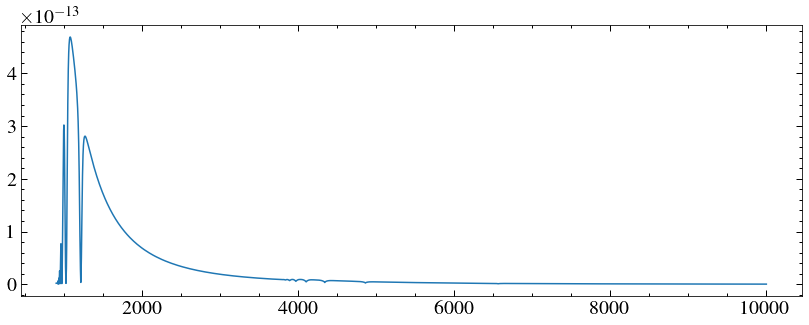

In [10]:
#model 
mw, mf = np.loadtxt('models/ldlc01010.dk', unpack=True, skiprows=34)
#plt.plot(mw, mf)

r = (0.0179*u.Rsun).to(u.m).value
dm = (d*u.pc).to(u.m).value
scale = (np.pi)*((r/dm)**2)*1e-8
print(scale)
plt.plot(mw, mf*scale)

[3.78247978e+30]


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error two minor releases later


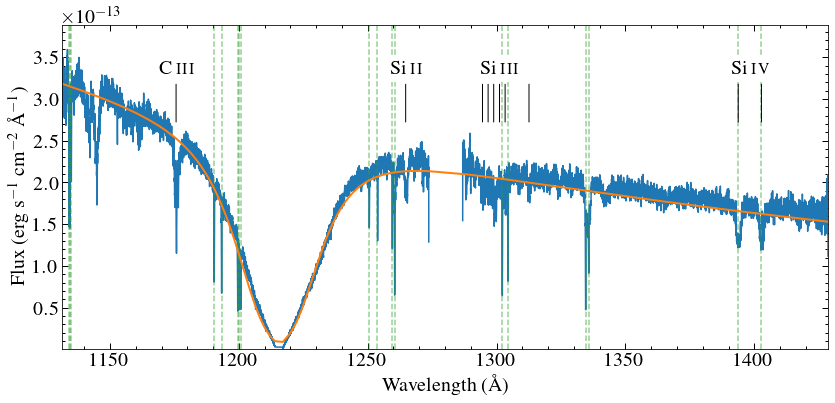

In [31]:
si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775,1402.770]
c3 = [1174.935, 1175.265, 1175.592, 1175.713, 1175.713, 1175.989, 1176.372]
plt.figure(figsize=(12, 6))
smooth = 5
x = x1ds[0]
data = fits.getdata(x,1)
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))    
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(wb[0], wb[-1])
plt.ylim(0.1e-14, 3.89e-13)

names = ['Si\,{\sc ii}', 'Si\,{\sc iii}', 'Si\,{\sc iv}', 'C\,{\sc iii}']
lines = [si2, si3, si4, [np.mean(c3)]]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 3.e-13), xytext=(np.mean(si), 3.3e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

    

def residuals(scale, f, mf):
    return f - mf/scale
    
mmask = (mw > wb[0]) & (mw < wb[-1])
mw1, mf1 = mw[mmask], mf[mmask]

mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(wb)
normfac = leastsq(residuals, 1., args=(fb, mf1))[0]

print(normfac)
    
plt.plot(wb, mf1/normfac, c='C1', lw=2)

plt.tight_layout()
plt.savefig('plots/cc_cet_cos.pdf', dpi=300)
plt.savefig('plots/cc_cet_cos.png',dip=150, facecolor='white')

In [12]:
"""x = x1ds[1]
data = fits.getdata(x,1)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    plt.plot(w, f)
    
w2, f2, e2, dq2 = np.loadtxt('CC-Cet_ldlc51010.dat', unpack=True)
plt.plot(w2, f2)
plt.xlim(1300, 1350)
plt.ylim(0, 0.5e-12)"""

"x = x1ds[1]\ndata = fits.getdata(x,1)\nfor dt in data[::-1]:\n    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']\n    plt.plot(w, f)\n    \nw2, f2, e2, dq2 = np.loadtxt('CC-Cet_ldlc51010.dat', unpack=True)\nplt.plot(w2, f2)\nplt.xlim(1300, 1350)\nplt.ylim(0, 0.5e-12)"

In [13]:
"""x = '/media/david/5tb_storage1/pceb_data/ldlc04010_x1dsum.fits'
data = fits.getdata(x,1)
rootname = fits.getheader(x, 0)['ASN_ID']
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
dqb = np.array([], dtype=int)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    #w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))
    dqb = np.concatenate((dqb, dq))
savdat = Table([wb, fb, eb, dqb], names=['#WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])
ascii.write(savdat, 'LM-COM_'+rootname.lower()+'.dat', format='basic', overwrite=True)"""

"x = '/media/david/5tb_storage1/pceb_data/ldlc04010_x1dsum.fits'\ndata = fits.getdata(x,1)\nrootname = fits.getheader(x, 0)['ASN_ID']\nwb = np.array([], dtype=float)\nfb = np.array([], dtype=float)\neb = np.array([], dtype=float)\ndqb = np.array([], dtype=int)\nfor dt in data[::-1]:\n    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']\n   # mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) \n    #w, f, e = w[mask], f[mask], e[mask]\n    wb = np.concatenate((wb, w))\n    fb = np.concatenate((fb, f))\n    eb = np.concatenate((eb, e))\n    dqb = np.concatenate((dqb, dq))\nsavdat = Table([wb, fb, eb, dqb], names=['#WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])\nascii.write(savdat, 'LM-COM_'+rootname.lower()+'.dat', format='basic', overwrite=True)"

Making plots with the magnetic models

In [14]:

mods = glob.glob('magnetic_models/*1400*.dat')
mods.sort()
print(mods)

['magnetic_models/cccet-1400-B630kG-40kms-01-plot.dat', 'magnetic_models/cccet-1400-B710kG-40kms-02-plot.dat', 'magnetic_models/lmcom-1400-0kG-plot.dat']


Adding another spectrum to compare with

In [15]:
"""def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    fitter = fitting.LinearLSQFitter()
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 5
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne

wc, fc, ec, dqc = np.loadtxt('LM-COM_ldlc04010.dat', unpack=True) #picking lm com for now, might change!
mask2 = (wc > 1390) & (wc < 1410)
mask1 = (wc > 1390) & (wc < 1392) | (wc > 1395) & (wc < 1401) | (wc > 1405) & (wc < 1410)
wn, fn, en = make_plot_spec(wc, fc, ec, mask1, mask2)
plt.plot(wn, fn)"""

"def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot\n    fitter = fitting.LinearLSQFitter()\n    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines\n    w1, f1 = w[mask1], f[mask1]\n    n_init = models.Polynomial1D(3)\n    n_fit = fitter(n_init, w1, f1)\n    #mask = (w > 8450) & (w < 8700)\n    w1, f1, e1 = w[mask2], f[mask2], e[mask2]\n    nf = f1/n_fit(w1)\n    ne = e1/n_fit(w1)\n    smooth = 5\n    nf = convolve(nf,Box1DKernel(smooth))\n    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5\n    return w1,nf, ne\n\nwc, fc, ec, dqc = np.loadtxt('LM-COM_ldlc04010.dat', unpack=True) #picking lm com for now, might change!\nmask2 = (wc > 1390) & (wc < 1410)\nmask1 = (wc > 1390) & (wc < 1392) | (wc > 1395) & (wc < 1401) | (wc > 1405) & (wc < 1410)\nwn, fn, en = make_plot_spec(wc, fc, ec, mask1, mask2)\nplt.plot(wn, fn)"

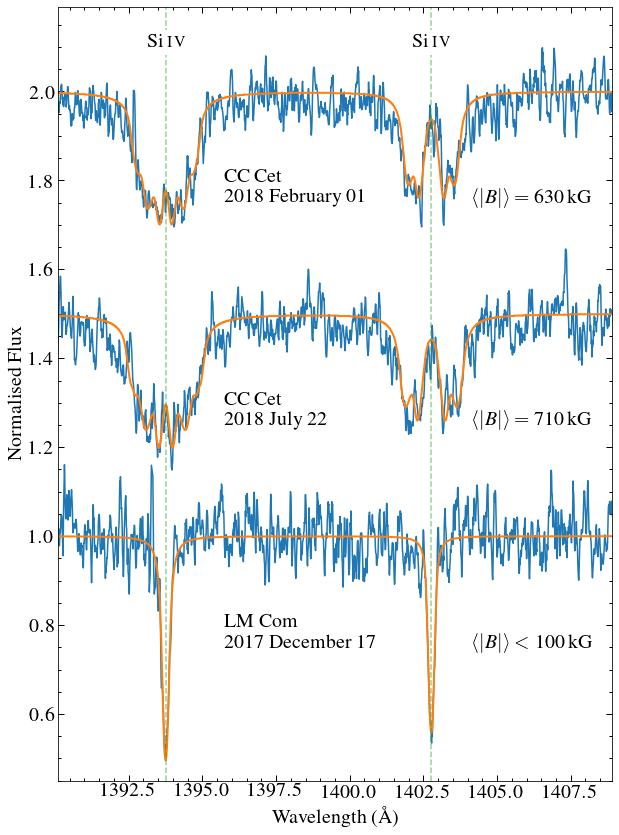

In [27]:
mods = ['magnetic_models/lmcom-1400-0kG-plot.dat', 'magnetic_models/cccet-1400-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1400-B630kG-40kms-01-plot.dat']


si4 = [1393.775,1402.770]
dates = ['LM Com \n 2017~December~17','CC\,Cet \n 2018~July~22', 'CC\,Cet \n 2018~February~01']
Bs = [100, 710, 630]

plt.figure(figsize = (9, 12))
for i, mod in enumerate(mods):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(5))
    if i == 0:
        mask = (w <   1393.280) | (w > 1393.310)
        w, f, m = w[mask], f[mask], m[mask]
    plt.plot(w,f+0.5*i, c='C0')
    plt.plot(w, m+0.5*i, lw=2, c='C1')
    
    #if i == 0:
        #[plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
    #    plt.xticks(visible=False)
    plt.xlim(1390.1, 1408.9)
    plt.ylabel('Normalised Flux')
    if i == 1:
        plt.xlabel('Wavelength (\AA)')
    plt.annotate(dates[i], (0.3, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
    if i > 0:
        plt.annotate(r'$\langle \vert B \vert \rangle = {}$\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
    else:
        plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.75, 0.75+(0.5*i)), xycoords = ('axes fraction', 'data'))
plt.ylim(0.45, 2.19)

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in si4]
[plt.annotate('Si\,{\sc iv}',(line, 1), xytext=(line, 2.1), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for line in si4]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)
plt.savefig('plots/siiv_lines.pdf', dpi=300)
plt.savefig('plots/siiv_lines.png', dpi=150, facecolor='white')
    #plt.show()


In [17]:
mods = glob.glob('magnetic_models/cccet*1300*.dat')
#mods.sort()
mods = mods[::-1]
print(mods)

['magnetic_models/cccet-1300-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1300-B630kG-40kms-01-plot.dat']


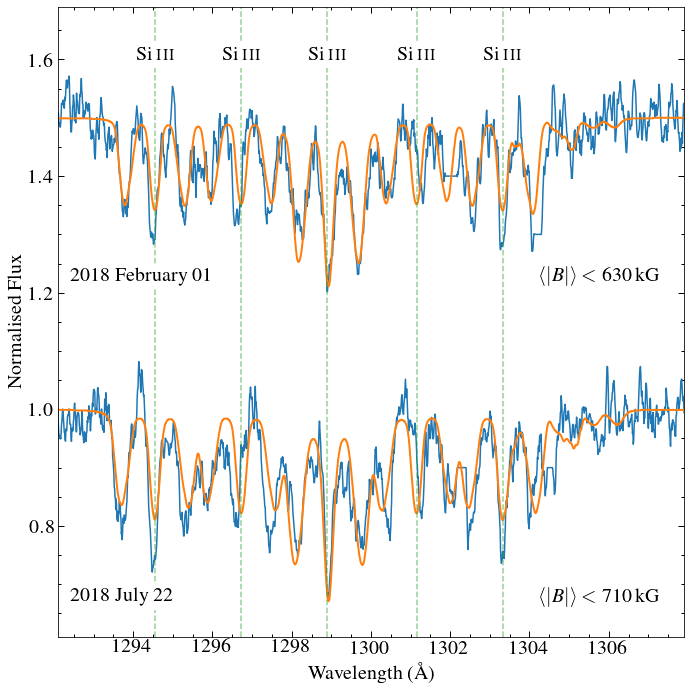

In [18]:
dates = ['2018~July~22', '2018~February~01']
Bs = [710, 630]

si3 = [1294.545,1296.726,1298.892,1301.149,1303.323]#,1312.591]

plt.figure(figsize = (10, 10))
for i, mod in enumerate(mods):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(5))
    plt.plot(w,f+0.5*i, c='C0')
    plt.plot(w, m+0.5*i, lw=2, c='C1')
    
    plt.xlim(1292.1, 1307.9)
    plt.ylabel('Normalised Flux')
    if i == 1:
        plt.xlabel('Wavelength (\AA)')
    plt.annotate(dates[i], (0.02, 0.67+(0.55*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
    plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.77, 0.67+(0.55*i)), xycoords = ('axes fraction', 'data'))
plt.ylim(0.61, 1.69)

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in si3]
[plt.annotate('Si\,{\sc iii}',(line, 1), xytext=(line, 1.6), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for line in si3]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)
plt.savefig('plots/nolm_siiii_lines.pdf')

See what it looks like with LM com as well

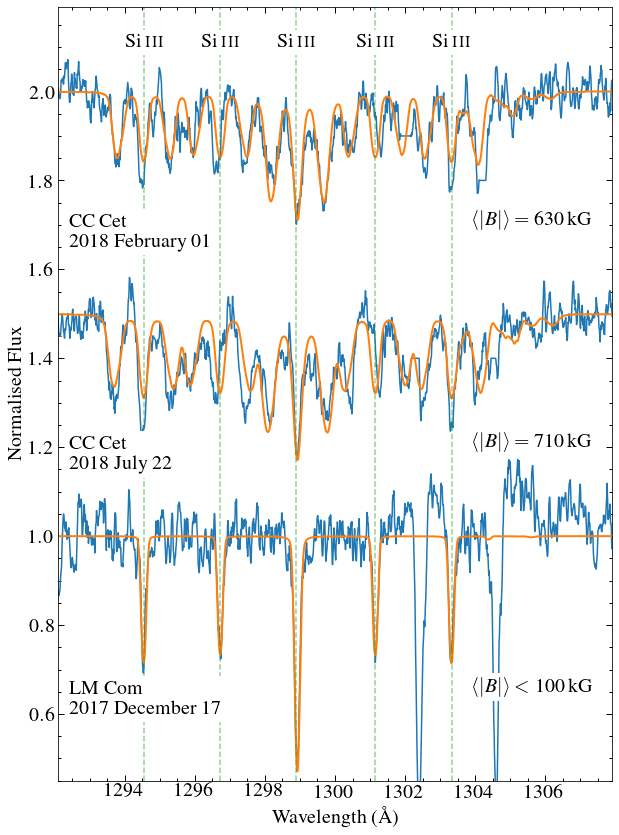

In [30]:
mods = ['magnetic_models/lmcom-1300-0kG-plot.dat','magnetic_models/cccet-1300-B710kG-40kms-02-plot.dat', 'magnetic_models/cccet-1300-B630kG-40kms-01-plot.dat']

dates = ['LM Com \n 2017~December~17','CC\,Cet \n 2018~July~22', 'CC\,Cet \n 2018~February~01']
Bs = [100, 710, 630]

plt.figure(figsize = (9, 12))
for i, mod in enumerate(mods):
    w, f, m = np.loadtxt(mod, unpack=True)
    f = convolve(f,Box1DKernel(5))
    if i == 0:
        mask = (w <   1393.280) | (w > 1393.310)
        w, f, m = w[mask], f[mask], m[mask]
    plt.plot(w,f+0.5*i, c='C0')
    plt.plot(w, m+0.5*i, lw=2, c='C1')
    
    #if i == 0:
        #[plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
    #    plt.xticks(visible=False)
    plt.xlim(1292.1, 1307.9)
    plt.ylabel('Normalised Flux')
    if i == 1:
        plt.xlabel('Wavelength (\AA)')
   
    if i > 0:
        plt.annotate(r'$\langle \vert B \vert \rangle = {}$\,kG'.format(Bs[i]), (0.75, 0.7+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
        plt.annotate(dates[i], (0.02, 0.65+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
    else:
        plt.annotate(r'$\langle \vert B \vert \rangle  <$ {}\,kG'.format(Bs[i]), (0.75, 0.65+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
        plt.annotate(dates[i], (0.02, 0.6+(0.5*i)), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
plt.ylim(0.45, 2.19)

#plt.plot(wn, fn+1)
[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in si3]
[plt.annotate('Si\,{\sc iii}',(line, 1), xytext=(line, 2.1), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none')) for line in si3[:-1]]
#plt.annotate('LM Com', (0.75, 1.8), xycoords = ('axes fraction', 'data'), bbox=dict(facecolor='white', edgecolor='none'))
plt.tight_layout()
#plt.subplots_adjust(hspace=0.02)
plt.savefig('plots/siiii_lines.pdf', dpi=300)
plt.savefig('plots/siiii_lines.png', dpi=150, facecolor='white')

Saving a scaled model for use in the COS etc.

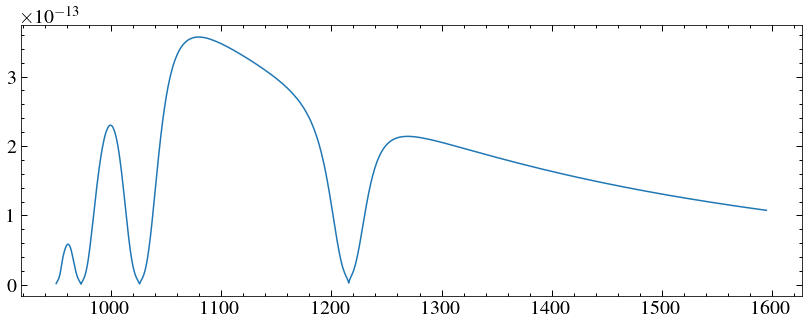

In [20]:
mmask = (mw > 950) & (mw < 1600) #safe side to overlap g130m
mws, mfs = mw[mmask], mf[mmask]/normfac
plt.plot(mws, mfs)
savdat = Table([mws, mfs], names=['#WAVELENGTH', 'FLUX'])
ascii.write(savdat, 'models/CC_CET_scaled_fuv_model.dat', format='basic', overwrite=True)